## **Mengimpor libaries** 

In [1]:
# Mengimpor libaries pandas,numpy dan json untuk memproses data dalam format JSON
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

# import warning to ignore warning
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

## **Install mysql connector**

In [2]:
# install mysql connector
!pip install mysql-connector-python

In [3]:
# import libraries
import mysql.connector
from mysql.connector import Error

In [4]:
# Define MySQL details
host   = 'okegarden-laravel-prod-db-2024-11-15-0200.cgwhhgh85mr3.ap-southeast-3.rds.amazonaws.com'
port   = '3306'
user   = 'intern_mes'
passwd = 'sdfDFLES342982Ddlsdksd'
databs = 'okegarden_laravel_prod_db'

In [5]:
# function to fetch data from database, the connection is closed after use.
def fetch_data(host_name, port_name, user_name, user_password, db_name, query, params=None):
    try:
        # use with to ensure the connection is closed after use
        with mysql.connector.connect(
            host=host_name,
            port=port_name,
            user=user_name,
            password=user_password,
            database=db_name
        ) as connection:
            data = pd.read_sql(query, connection, params=params) # read the query to dataframe format
            return data

    except Error as e:
        print(f"Error while connecting to MySQL or fetching data: {e}")
        return None

### **Query Data**

In [6]:
query = """

WITH order_garden_data AS (
    SELECT
        act.id,
        act.subject_type,
        act.subject_id,
        act.properties,
        act.created_at,
        act.updated_at,
        JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.status')) AS old_status,
        JSON_UNQUOTE(JSON_EXTRACT(properties, '$.old.created_at')) AS old_created_at,
        JSON_UNQUOTE(JSON_EXTRACT(properties, '$.old.updated_at')) AS old_updated_at,
        JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.status')) AS attributes_status,
        JSON_UNQUOTE(JSON_EXTRACT(properties, '$.attributes.created_at')) AS attributes_created_at,
        JSON_UNQUOTE(JSON_EXTRACT(properties, '$.attributes.updated_at')) AS attributes_updated_at,
        TIMESTAMPDIFF(SECOND, 
            JSON_UNQUOTE(JSON_EXTRACT(properties, '$.attributes.created_at')),
            JSON_UNQUOTE(JSON_EXTRACT(properties, '$.attributes.updated_at')) 
        ) / 3600 AS order_cycle_time,
        dt.id AS id_datetime,
        TIMESTAMPDIFF(SECOND,
            JSON_UNQUOTE(JSON_EXTRACT(properties, '$.old.updated_at')),
            act.created_at
        ) / 3600 AS time_interval_status
    FROM
        activity_log act
    LEFT JOIN
        datetime dt ON act.subject_id = dt.datetimeable_id
    WHERE 
        subject_type LIKE '%OrderDesign%' 
        OR subject_type LIKE '%OrderGarden%'
        OR subject_type LIKE '%OrderGardenCareDetail%'
        
),
build_start_attributes_status AS (
    SELECT
        act.id,
        act.subject_type,
        act.subject_id,
        act.properties,
        act.created_at,
        dt.updated_at,
        CASE
            WHEN JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.status')) = 'acc_gardener' 
                 AND JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.status')) = 'in_review'
            THEN 'acc_gardener'
        END AS old_status,
        JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.created_at')) AS old_created_at,
        JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.updated_at')) AS old_updated_at,
        CASE
            WHEN JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.status')) = 'acc_gardener' 
                 AND JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.status')) = 'in_review'
            THEN 'build_start'
        END AS attributes_status,
        dt.created_at AS attributes_created_at,
        dt.updated_at AS attributes_updated_at,
        TIMESTAMPDIFF(
            SECOND, 
            dt.created_at,
            dt.updated_at
        ) / 3600 AS order_cycle_time,
        dt.id AS id_datetime,
        TIMESTAMPDIFF(
            SECOND,
            JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.updated_at')),
            act.created_at
        ) / 3600 AS time_interval_status
    FROM
        activity_log act
    LEFT JOIN
        datetime dt ON act.subject_id = dt.datetimeable_id
    WHERE 
        (
            subject_type LIKE '%OrderDesign%' 
            OR subject_type LIKE '%OrderGarden%'
            OR subject_type LIKE '%OrderGardenCareDetail%'
        )
        AND JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.status')) = 'acc_gardener'
        AND JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.status')) = 'in_review'
),
build_start_old_status AS (
    SELECT
        act.id,
        act.subject_type,
        act.subject_id,
        act.properties,
        dt.created_at,
        dt.updated_at,
        CASE
            WHEN JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.status')) = 'acc_gardener' 
                 AND JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.status')) = 'in_review'
            THEN 'build_start' 
        END AS old_status,
        dt.created_at AS old_created_at,
        dt.datetime AS old_updated_at,
        CASE
            WHEN JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.status')) = 'acc_gardener' 
                 AND JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.status')) = 'in_review'
            THEN 'in_review'
        END AS attributes_status,
        JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.created_at')) AS attributes_created_at,
        JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.updated_at')) AS attributes_updated_at,
        TIMESTAMPDIFF(
            SECOND, 
            JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.created_at')),
            JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.updated_at'))
        ) / 3600 AS order_cycle_time,
        dt.id AS id_datetime,
        TIMESTAMPDIFF(
            SECOND,
            dt.created_at,
            dt.datetime
        ) / 3600 AS time_interval_status
    FROM
        activity_log act
    LEFT JOIN
        datetime dt ON act.subject_id = dt.datetimeable_id
    WHERE 
    (
        subject_type LIKE '%OrderDesign%' 
        OR subject_type LIKE '%OrderGarden%'
        OR subject_type LIKE '%OrderGardenCareDetail%'
    )
    AND JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.status')) = 'acc_gardener'
    AND JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.status')) = 'in_review'
)
SELECT * FROM (
SELECT * FROM order_garden_data
UNION ALL
SELECT * FROM build_start_attributes_status
UNION ALL
SELECT * FROM build_start_old_status) AS combined_data
ORDER BY id DESC;

"""
order_cycletime = fetch_data(host, port, user, passwd, databs, query)

### Kode SQL di atas digunakan untuk mengambil data dari tabel activity_log dengan fokus pada aktivitas tertentu yang terkait dengan jenis orderan : 

- **Kolom yang Dipilih:** Mengambil kolom seperti id, subject_type, subject_id, dan properties, serta ekstraksi nilai dari JSON dalam kolom properties untuk mendapatkan status dan waktu terkait.
- **Perhitungan Waktu:** Menghitung waktu siklus pesanan dalam jam dan hari dan selisih waktu antara status lama dan baru.
- **Filter Data:** Memilih entri berdasarkan tipe subjek (OrderDesign, OrderGarden, dan OrderGardenCareDetail) dan status tertentu ('finish' atau 'in_review').   
Penting untuk dicatat bahwa hanya orderan dengan status 'finish' yang dapat dihitung untuk order_cycle_time. Namun, untuk subjek OrderGardenCareDetail, yang tidak memiliki status 'finish', kami mengambil status 'in_review' sebagai alternatif untuk analisis.

## **Explore Data**
Dalam proyek ini, kami menggunakan tabel **activity_log** untuk mengambil semua perubahan data order yang terjadi pada tiga tabel utama, yaitu:

1. OrderDesign
2. OrderGarden
3. OrderGardenCareDetail

In [7]:
# Menampilkan 5 baris pertama data.
order_cycletime.head()

,id,subject_type,subject_id,properties,created_at,updated_at,old_status,old_created_at,old_updated_at,attributes_status,attributes_created_at,attributes_updated_at,order_cycle_time,id_datetime,time_interval_status
0,16519,App\Models\OrderDesign,1018,"{""attributes"":{""id_order"":1018,""id_user"":1968,...",2024-11-15 08:47:27,2024-11-15 08:47:27,None,None,None,paid,2024-11-15T01:47:27.000000Z,2024-11-15T01:47:27.000000Z,0.0000,NaN,NaN
1,16515,App\Models\OrderDesign,1017,"{""attributes"":{""id_order"":1017,""id_user"":1967,...",2024-11-15 08:32:14,2024-11-15 08:32:14,None,None,None,paid,2024-11-15T01:32:14.000000Z,2024-11-15T01:32:14.000000Z,0.0000,NaN,NaN
2,16509,App\Models\OrderGardenCareDetail,1160,"{""attributes"":{""id"":1160,""id_order_garden_care...",2024-11-14 22:36:51,2024-11-14 22:36:51,paid,2024-10-06T10:18:37.000000Z,2024-11-02T03:55:18.000000Z,acc_gardener,2024-10-06T10:18:37.000000Z,2024-11-14T15:36:51.000000Z,941.3039,NaN,306.6925
3,16478,App\Models\OrderGardenCareDetail,976,"{""attributes"":{""id"":976,""id_order_garden_care""...",2024-11-14 22:24:25,2024-11-14 22:24:25,paid,2024-09-21T05:12:37.000000Z,2024-10-30T06:31:36.000000Z,acc_gardener,2024-09-21T05:12:37.000000Z,2024-11-14T15:24:25.000000Z,1306.1967,NaN,375.8803
4,16475,App\Models\OrderGardenCare,291,"{""attributes"":{""id"":291,""id_user"":1207,""id_gar...",2024-11-14 21:00:23,2024-11-14 21:00:23,on_going,2024-11-13T03:48:28.000000Z,2024-11-14T13:36:27.000000Z,in_review,2024-11-13T03:48:28.000000Z,2024-11-14T14:00:23.000000Z,34.1986,NaN,7.3989


In [8]:
order_cycletime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1543 entries, 0 to 1542
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     1543 non-null   int64         
 1   subject_type           1543 non-null   object        
 2   subject_id             1543 non-null   int64         
 3   properties             1543 non-null   object        
 4   created_at             1492 non-null   datetime64[ns]
 5   updated_at             1441 non-null   datetime64[ns]
 6   old_status             1198 non-null   object        
 7   old_created_at         1147 non-null   object        
 8   old_updated_at         1147 non-null   object        
 9   attributes_status      1512 non-null   object        
 10  attributes_created_at  1472 non-null   object        
 11  attributes_updated_at  1472 non-null   object        
 12  order_cycle_time       1472 non-null   float64       
 13  id_

Berdasarkan hasil yang ditampilkan di atas, terdapat beberapa kolom seperti 
- **old_created_at**  
- **old_updated_at**  
- **attributes_created_at**  
- **attributes_updated_at**   
yang saat ini memiliki tipe data **object**.  

Tipe data ini belum sesuai dengan konteks data tersebut yang seharusnya berada dalam format **datetime**.Hal ini akan menjadi perhatian pada **tahap transformasi data**,   
di mana tipe data pada kolom-kolom tersebut akan diubah menjadi **datetime** agar lebih sesuai untuk analisis dan manipulasi data lebih lanjut.

In [9]:
# Memfilter data berdasarkan subject_type
proses_subject_type = order_cycletime[order_cycletime['subject_type'].isin(['App\Models\OrderDesign','App\Models\OrderGarden','App\Models\OrderGardenCareDetail'])]

Dalam proyek ini, kami menggunakan hasil join tabel **activity_log** dan tabel **datetime** untuk mengambil semua perubahan data order yang terjadi pada tiga tabel utama, yaitu:

1. **OrderDesign**
2. **OrderGarden**
3. **OrderGardenCareDetail**

In [10]:
# Filter baris pada dataframe proses_subject_type yang memiliki perubahan status
# (yaitu atribut 'attributes_status' tidak sama dengan 'old_status')
proses_subject_type = proses_subject_type[proses_subject_type['attributes_status'] != proses_subject_type['old_status']]

In [11]:
# Hapus baris duplikat pada dataframe proses_subject_type berdasarkan kolom 'subject_id', 'old_status', dan 'attributes_status'
# Jaga hanya baris pertama dari setiap grup duplikat
proses_subject_type = proses_subject_type.drop_duplicates(subset=['subject_id','old_status','attributes_status'], keep='first')

## **Data Transformation**

##### Pada tahap ini, kami melakukan serangkaian transformasi data yang bertujuan untuk mempersiapkan dataset agar lebih siap untuk analisis mendalam.  
##### Transformasi ini mencakup dua aspek utama: pembuatan kolom baru dan pengubahan tipe data.

In [12]:
order_cycletime.head(3)

,id,subject_type,subject_id,properties,created_at,updated_at,old_status,old_created_at,old_updated_at,attributes_status,attributes_created_at,attributes_updated_at,order_cycle_time,id_datetime,time_interval_status
0,16519,App\Models\OrderDesign,1018,"{""attributes"":{""id_order"":1018,""id_user"":1968,...",2024-11-15 08:47:27,2024-11-15 08:47:27,None,None,None,paid,2024-11-15T01:47:27.000000Z,2024-11-15T01:47:27.000000Z,0.0000,NaN,NaN
1,16515,App\Models\OrderDesign,1017,"{""attributes"":{""id_order"":1017,""id_user"":1967,...",2024-11-15 08:32:14,2024-11-15 08:32:14,None,None,None,paid,2024-11-15T01:32:14.000000Z,2024-11-15T01:32:14.000000Z,0.0000,NaN,NaN
2,16509,App\Models\OrderGardenCareDetail,1160,"{""attributes"":{""id"":1160,""id_order_garden_care...",2024-11-14 22:36:51,2024-11-14 22:36:51,paid,2024-10-06T10:18:37.000000Z,2024-11-02T03:55:18.000000Z,acc_gardener,2024-10-06T10:18:37.000000Z,2024-11-14T15:36:51.000000Z,941.3039,NaN,306.6925


In [13]:
# Menampilkan tipe data dari setiap kolom dalam DataFrame 'order_cycletime'
order_cycletime.dtypes

id                                int64
subject_type                     object
subject_id                        int64
properties                       object
created_at               datetime64[ns]
updated_at               datetime64[ns]
old_status                       object
old_created_at                   object
old_updated_at                   object
attributes_status                object
attributes_created_at            object
attributes_updated_at            object
order_cycle_time                float64
id_datetime                     float64
time_interval_status            float64
dtype: object

In [14]:
# Mengonversi kolom 'old_created_at' menjadi tipe datetime dan menghapus informasi zona waktu
order_cycletime['old_created_at'] = pd.to_datetime(order_cycletime['old_created_at'], errors='coerce')
order_cycletime['old_created_at'] = pd.to_datetime(order_cycletime['old_created_at'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.tz_localize(None)

# Mengonversi kolom 'old_updated_at' menjadi tipe datetime dan menghapus informasi zona waktu
order_cycletime['old_updated_at'] = pd.to_datetime(order_cycletime['old_updated_at'], errors='coerce')
order_cycletime['old_updated_at'] = pd.to_datetime(order_cycletime['old_updated_at'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.tz_localize(None)

# Mengonversi kolom 'attributes_created_at' menjadi tipe datetime dan menghapus informasi zona waktu
order_cycletime['attributes_created_at'] = pd.to_datetime(order_cycletime['attributes_created_at'], errors='coerce')
proses_subject_type['attributes_created_at'] = pd.to_datetime(order_cycletime['attributes_created_at'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.tz_localize(None)

# Mengonversi kolom 'attributes_updated_at' menjadi tipe datetime dan menghapus informasi zona waktu
order_cycletime['attributes_updated_at'] = pd.to_datetime(order_cycletime['attributes_updated_at'], errors='coerce')
order_cycletime['attributes_updated_at'] = pd.to_datetime(order_cycletime['attributes_updated_at'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.tz_localize(None)

In [15]:
# Menampilkan tipe data dari setiap kolom dalam DataFrame 'order_cycletime'
order_cycletime.dtypes

id                                     int64
subject_type                          object
subject_id                             int64
properties                            object
created_at                    datetime64[ns]
updated_at                    datetime64[ns]
old_status                            object
old_created_at                datetime64[ns]
old_updated_at                datetime64[ns]
attributes_status                     object
attributes_created_at    datetime64[ns, UTC]
attributes_updated_at         datetime64[ns]
order_cycle_time                     float64
id_datetime                          float64
time_interval_status                 float64
dtype: object

##### Setelah dilakukan proses transformasi data, tipe data pada kolom `old_created_at`, `old_updated_at`, `attributes_created_at`, dan `attributes_updated_at` telah berhasil diubah dari tipe object menjadi tipe datetime. Perubahan ini memastikan bahwa data pada kolom-kolom tersebut lebih sesuai dengan konteksnya, yaitu merepresentasikan nilai waktu dan tanggal.

In [16]:
proses_subject_type.shape

(861, 15)

## **Analysis and Visualization**
Tahap "Analysis and Visualization" (Analisis dan Visualisasi) adalah langkah krusial dalam proses eksplorasi data. Dalam konteks ini, kita berfokus pada dua aspek utama: ringkasan **statistik (summary statistics)** dan **visualisasi data**

In [17]:
# Ringkasan statistik Type Data Numerik.
proses_subject_type.describe()

,id,subject_id,created_at,updated_at,attributes_created_at,order_cycle_time,id_datetime,time_interval_status
count,861.000000,861.000000,811,761,780,792.000000,262.000000,552.000000
mean,7516.763066,956.945412,2024-11-03 20:48:40.780517888,2024-11-03 17:12:42.189224704,2024-10-15 10:08:19.946153728,457.720041,79.393130,204.383777
min,3.000000,19.000000,2024-08-25 18:29:15,2024-08-25 18:29:15,2024-06-28 02:45:41,0.000000,8.000000,3.510000
25%,2174.000000,816.000000,2024-10-28 12:29:05,2024-10-28 15:32:38,2024-10-11 03:12:41,0.000000,58.250000,7.258150
50%,4331.000000,988.000000,2024-11-04 06:50:59,2024-11-04 07:07:38,2024-10-28 00:37:28,27.095300,75.500000,27.857500
75%,13941.000000,1340.000000,2024-11-10 17:30:10,2024-11-10 17:30:10,2024-11-05 05:28:44,560.436375,102.000000,134.853075
max,16519.000000,1498.000000,2024-11-15 08:47:27,2024-11-15 08:47:27,2024-11-15 01:47:27,3246.923900,138.000000,3219.215300
std,5892.647478,417.783156,NaN,NaN,NaN,807.073478,29.789717,474.598688


Fokus pada kolom `order_cycle_time` memberikan wawasan penting mengenai waktu yang dibutuhkan untuk menyelesaikan siklus pesanan.  
Melalui ringkasan statistik deskriptif, kita dapat memahami karakteristik dasar dari data ini, yang mencakup berbagai metrik kunci.

#### **Menghitung Rata-Rata Order Cycle time**

In [18]:
avg_order_cycle_time_order = proses_subject_type[proses_subject_type['attributes_status'].isin(['finish'])]
avg_order_cycle_time_order = avg_order_cycle_time_order.groupby('subject_type')['order_cycle_time'].mean().reset_index()
avg_order_cycle_time_order['order_cycle_time_days'] = avg_order_cycle_time_order['order_cycle_time'].apply(lambda x: f"{int(x // 24)} Hari")

avg_order_cycle_time_care = proses_subject_type[(proses_subject_type['subject_type'] == 'App\\Models\\OrderGardenCareDetail') & (proses_subject_type['attributes_status'] == 'in_review')]
avg_order_cycle_time_care = avg_order_cycle_time_care.groupby('subject_type')['order_cycle_time'].mean().reset_index()
avg_order_cycle_time_care['order_cycle_time_days'] = avg_order_cycle_time_care['order_cycle_time'].apply(lambda x: f"{int(x // 24)} Hari")

combined_order_cycle_time_avg = pd.concat([avg_order_cycle_time_order, avg_order_cycle_time_care], ignore_index=True)
combined_order_cycle_time_avg.rename(columns={'subject_type': 'Jenis Order', 'order_cycle_time': 'order_cycle_time', 'order_cycle_time_days': 'days'}, inplace=True)
combined_order_cycle_time_avg.reset_index(drop=True)

,Jenis Order,order_cycle_time,days
0,App\Models\OrderDesign,865.789567,36 Hari
1,App\Models\OrderGarden,295.461300,12 Hari
2,App\Models\OrderGardenCareDetail,1078.391605,44 Hari


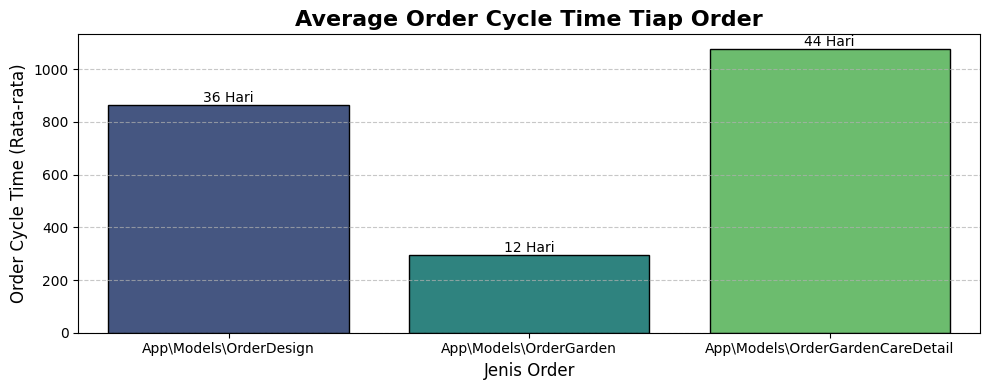

In [19]:
plt.figure(figsize=(10, 4))  # Atur ukuran figure
barplot = sns.barplot(
    x='Jenis Order',
    y='order_cycle_time',
    data=combined_order_cycle_time_avg,
    palette='viridis',  
    edgecolor='black'  
)

plt.title('Average Order Cycle Time Tiap Order', fontsize=16, fontweight='bold')
plt.xlabel('Jenis Order', fontsize=12)
plt.ylabel('Order Cycle Time (Rata-rata)', fontsize=12)

# Menambahkan label untuk setiap bar menggunakan kolom order_cycle_time_days
for index, row in combined_order_cycle_time_avg.iterrows():
    barplot.text(
        index, 
        row['order_cycle_time'], 
        row['days'],  # Menggunakan kolom yang sudah ada sebagai label
        color='black', 
        ha="center", 
        va="bottom"
    )

# Menyesuaikan tampilan
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # tambahan garis grid pada sumbu Y

# Tampilkan plot
plt.tight_layout()
plt.show()

#### Visualisasi batang di atas secara jelas menunjukkan perbedaan waktu siklus rata-rata untuk tiga jenis order yang berbeda.

- **OrderDesign**: Membutuhkan waktu rata-rata 37 hari untuk diselesaikan.
- **OrderGarden**: Merupakan jenis order yang paling cepat diselesaikan, hanya membutuhkan waktu rata-rata 20 hari.
- **OrderGardenCareDetail**: Merupakan jenis order yang paling lambat diselesaikan, membutuhkan waktu rata-rata 44 hari.

#### **Menghitung Median Order Cycle time**

In [20]:
med_order_cycle_time_order = proses_subject_type[proses_subject_type['attributes_status'].isin(['finish'])]
med_order_cycle_time_order = med_order_cycle_time_order.groupby('subject_type')['order_cycle_time'].median().reset_index()
med_order_cycle_time_order['order_cycle_time_days'] = med_order_cycle_time_order['order_cycle_time'].apply(lambda x: f"{int(x // 24)} Hari")

med_order_cycle_time_care = proses_subject_type[(proses_subject_type['subject_type'] == 'App\\Models\\OrderGardenCareDetail') & (proses_subject_type['attributes_status'] == 'in_review')]
med_order_cycle_time_care = med_order_cycle_time_care.groupby('subject_type')['order_cycle_time'].median().reset_index()
med_order_cycle_time_care['order_cycle_time_days'] = med_order_cycle_time_care['order_cycle_time'].apply(lambda x: f"{int(x // 24)} Hari")

combined_order_cycle_time_med = pd.concat([med_order_cycle_time_order, med_order_cycle_time_care], ignore_index=True)
combined_order_cycle_time_med.reset_index(drop=True)

,subject_type,order_cycle_time,order_cycle_time_days
0,App\Models\OrderDesign,786.1175,32 Hari
1,App\Models\OrderGarden,230.3589,9 Hari
2,App\Models\OrderGardenCareDetail,764.2339,31 Hari


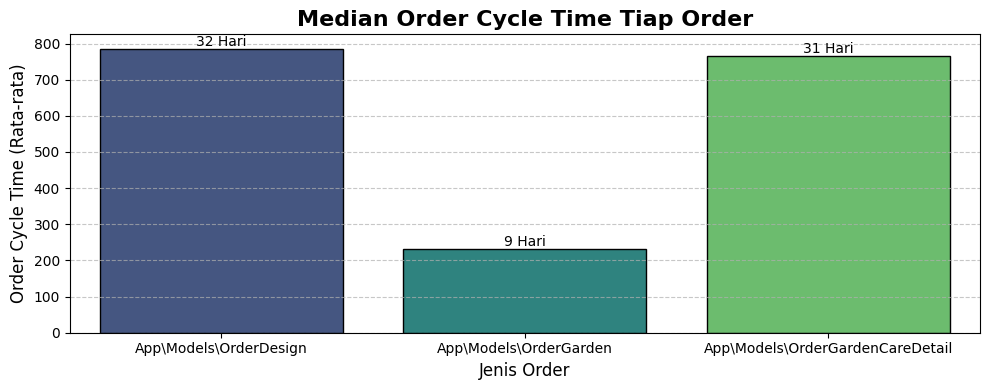

In [21]:
plt.figure(figsize=(10, 4))  # Atur ukuran figure
barplot = sns.barplot(
    x='subject_type',
    y='order_cycle_time',
    data=combined_order_cycle_time_med,
    palette='viridis',  
    edgecolor='black'  
)

plt.title('Median Order Cycle Time Tiap Order', fontsize=16, fontweight='bold')
plt.xlabel('Jenis Order', fontsize=12)
plt.ylabel('Order Cycle Time (Rata-rata)', fontsize=12)

# Menambahkan label untuk setiap bar menggunakan kolom order_cycle_time_days
for index, row in combined_order_cycle_time_med.iterrows():
    barplot.text(
        index, 
        row['order_cycle_time'], 
        row['order_cycle_time_days'],  # Menggunakan kolom yang sudah ada sebagai label
        color='black', 
        ha="center", 
        va="bottom"
    )

# Menyesuaikan tampilan
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # tambahan garis grid pada sumbu Y

# Tampilkan plot
plt.tight_layout()
plt.show()

### Berdasarkan median nya:
- **OrderGarden** adalah jenis pesanan yang paling cepat diselesaikan, hanya membutuhkan waktu rata-rata 14 hari.
- **OrderDesign** membutuhkan waktu rata-rata 29 hari untuk diselesaikan.
- **OrderGardenCareDetail** adalah jenis pesanan yang paling lama diselesaikan, membutuhkan waktu rata-rata 31 hari.  